In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_percentage_error as mean_ape
from sklearn.metrics import root_mean_squared_error as root_mse

In [2]:
model_data = pd.read_parquet("data/model_data.parquet")
model_data = model_data[model_data['alignement_politique'] != 'autre']

model_data['pres_votes_share'] = model_data['pres_dummy'] * model_data['pres_votes_share']

In [3]:
nuances_order = [
    "extremedroite_droiteradicale",
    "centredroite_droite",
    "centre",
    "centregauche_gauche",
    "extremegauche_gaucheradicale"
]

Approche économétrique classique : on modélise des comportements réels.
On s'intéresse principalement aux coefficients et à leur significativité.

$R^2$ n'est pas une mesure appropriée pour comparer des modèles ajustés sur des échantillons différents, et en l'absence de constante.

Il faut mesurer directement la distance entre les valeurs réelles et prédites.
De préférence en normalisant, car les valeurs prédites sont assez différentes entre les partis : un écart moyen de 5 pp. entre les valeurs réelles et prédites est mineur lorsque les valeurs prédites gravitent autour de 50 %, majeur lorsqu'elles gravitent autour de 5 %.
- *Mean absolute percentage error (MAPE)* : $\frac{1}{n} \sum_{i=1}^{n} \left| \frac{\hat{y}_i - y_i}{y_i} \right|$

    S'interprète directement : une MAPE de 1 signifie que les valeurs prédites s'écartent en moyenne de 100 % des valeurs réelles.
- *Root mean squared percentage error (RMSPE)*: $\sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}$

    Ne s'interprète pas directement. Permet seulement de comparer les modèles. Plus sensible aux outliers que la MAPE.

Elimination des constantes, qui rendent les coefficients beaucoup plus difficiles à interpréter sans améliorer sensiblement les prédictions (on se retrouve par exemple avec des constantes très élevées, et des coefficients négatifs pour les résultats électoraux).

## 1. Modèle de base = sièges à l'AN
De la forme $Y_{i} = \beta T_{i}$ avec :
- $Y_{i}$ la proportion des articles intégrant des citations de la nuance politique $i$ (avec $\sum_{i=1}^{n} Y_{i} = 1$)
- $\beta$ la pondération du nombre de sièges détenus les différentes nuances politiques représentées à l'Assemblée
- $T_{i}$ la proportion des sièges détenus par la nuance politique $i$

In [4]:
X = model_data["na_share"]
y = model_data["quotes_share"]
model = sm.OLS(y, X).fit(cov_type='HC3')
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

              coef  pval
na_share  0.903874   0.0

MAPE: 65.01%
RMSPE: 0.45052


## 2. Sièges à l'AN + participation au gouvernement
De la forme $Y_{i} = \beta T_{i} + \gamma G_{i}$ avec :
- $\gamma$ la proportion des articles intégrant des citations dont bénéficie la nuance politique du gouvernement
- $G_{i}$ une indicatrice valant 1 si le Premier ministre appartient à la nuance politique $i$

In [5]:
X = model_data[["na_share", "government"]]
y = model_data["quotes_share"]
model = sm.OLS(y, X).fit(cov_type='HC3')
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                coef          pval
na_share    0.873066  0.000000e+00
government  0.024397  7.172595e-07

MAPE: 64.09%
RMSPE: 0.44967


## 3. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives
Les modèles estimés sont de la forme $Y_{i} = \beta T_{i} + \gamma G_{i} + \theta P_{i} + \delta L_{i}$ avec :
- $\theta$ la pondération des résultats aux élections présidentielles des différentes nuances politiques
- $P_{i}$ la proportion des voix obtenues par la nuance politique $i$ à l'élection présidentielle suivante (pour le mois de l'élection et les trois précédents)
- $\delta$ la pondération des résultats aux élections législatives des différentes nuances politiques
- $L_{i}$ la proportion des voix obtenues par la nuance politique $i$ à l'élection législative précédente

In [6]:
X = model_data[["na_share", "government", "pres_votes_share", "leg_votes_share"]]
y = model_data["quotes_share"]
model = sm.OLS(y, X).fit(cov_type='HC3')
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

params = model.params.rename("coef").to_frame()
pvalues = model.pvalues.rename("pval").to_frame()
print(pd.merge(params, pvalues, left_index=True, right_index=True))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                      coef           pval
na_share          0.416011  2.740906e-271
government        0.081492   4.486431e-63
pres_votes_share  0.013555   6.490777e-01
leg_votes_share   0.827690   0.000000e+00

MAPE: 62.92%
RMSPE: 0.39388


## 4. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives + nuances politiques
Les modèles estimés sont de la forme $Y_{i} = \beta_{i} T_{i} + \gamma_{i} G_{i} + \theta_{i} P_{i} + \delta_{i} L_{i}$ : les effets deviennent spécifiques à chaque nuance politique.

In [7]:
models = {}

for alignement in model_data["alignement_politique"].unique():
    subset = model_data[model_data["alignement_politique"] == alignement]

    if len(subset) >= 3:
        X = subset[["na_share", "government", "pres_votes_share", "leg_votes_share"]]
        y = subset["quotes_share"]
        model = sm.OLS(y, X).fit(cov_type='HC3')      
        y_pred = model.predict(X)
        mape = mean_ape(y, y_pred)
        rmspe = root_mse(y, y_pred) / y.mean()
        
        models[alignement] = {
            "params": model.params.rename("params").to_frame(),
            "pvalues": model.pvalues.rename("pval").to_frame(),
            "mape": mape,
            "rmspe": rmspe}

    else:
        models[alignement] = {
            "params": None,
            "pvalues": None,
            "mape": None,
            "rmspe": None}

In [8]:
summary = []

for alignement, model_info in models.items():
    summary.append({
        "alignement": alignement,
        "mape": model_info["mape"],
        "rmspe": model_info["rmspe"]
    })

results = pd.DataFrame(summary)
results["alignement"] = pd.Categorical(results["alignement"], categories=nuances_order, ordered=True)
results = results.sort_values("alignement").reset_index(drop=True)

results.style.hide(axis="index") 

alignement,mape,rmspe
extremedroite_droiteradicale,0.676699,0.865419
centredroite_droite,0.213443,0.213403
centre,1.148850,0.530928
centregauche_gauche,0.293901,0.326749
extremegauche_gaucheradicale,0.661616,0.864017


In [9]:
results_list = []

for alignement, model_info in models.items():
    df = model_info["params"].join(model_info["pvalues"])
    df["alignement"] = alignement
    df["variable"] = df.index
    results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results = results.dropna(subset=["pval"])
results["alignement"] = pd.Categorical(results["alignement"], categories=nuances_order, ordered=True)
results = results.sort_values(["variable", "alignement"])
results = results.set_index(["variable", "alignement"])
results.index.names = ["Variable", "Alignement"]

results.style.format("{:.4f}")

## 5. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives + nuances politiques + périodes
Il s'agit maintenant d'étudier plus directement l'hypothèse d'une légitimation de l'extrême droite par la presse écrite nationale. La méthode la plus simple est d'estimer les modèles précédents pour 2 périodes, afin d'observer l'évolution des coefficients. Les modèles estimés sont de la forme $Y_{it} = \beta_{it} T_{it} + \gamma_{it} G_{it} + \theta_{it} P_{it} + \delta_{it} L_{it}$ : les effets deviennent spécifiques à chaque période $t$.

On retient 2012 comme charnière, avec l'idée que...
- La période précédente est encore marquée par le jeu fonctionnement traditionnel du système politique, avec une domination persistante de la droite et de la gauche de gouvernement, malgré leurs recompositions.
- La période suivante est caractérisée par l'effondrement de ce système, avec l'essort du centre et des extrêmes.

In [10]:
cutoff = pd.Period('2012-06', freq='M')

models = {}

for period_label, period_filter in {
    'pre2012': model_data["month"] < cutoff,
    'post2012': model_data["month"] >= cutoff
}.items():
    
    models[period_label] = {}
    period_data = model_data[period_filter]
    
    for alignement in period_data["alignement_politique"].unique():
        models[period_label][alignement] = {}
        subset = period_data[period_data["alignement_politique"] == alignement]

        if len(subset) >= 3:
            X = subset[["na_share", "government", "pres_votes_share", "leg_votes_share"]]
            y = subset["quotes_share"]            
            model = sm.OLS(y, X).fit(cov_type='HC3')
            y_pred = model.predict(X)
            mape = mean_ape(y, y_pred)
            rmspe = root_mse(y, y_pred) / y.mean()

            models[period_label][alignement] = {
                "params": model.params.rename("params").to_frame(),
                "pvalues": model.pvalues.rename("pval").to_frame(),
                "mape": mape,
                "rmspe": rmspe}

        else:
            models[period_label][alignement] = {
                "params": None,
                "pvalues": None,
                "mape": None,
                "rmspe": None}

In [11]:
summary_list = []

for period, alignement_dict in models.items():
    for alignement, model_info in alignement_dict.items():
        summary_list.append({
            "period": period,
            "alignement": alignement,
            "mape": model_info["mape"],
            "rmspe": model_info["rmspe"]
        })

summary = pd.DataFrame(summary_list)
summary["alignement"] = pd.Categorical(summary["alignement"], categories=nuances_order, ordered=True)
summary = summary.pivot_table(index="alignement",
                                      columns="period",
                                      values=["mape", "rmspe"],
                                      observed=False)
summary.columns = summary.columns.swaplevel(0, 1)
summary = summary.reindex(columns=["pre2012", "post2012"], level=0)
summary = summary.reset_index()
summary.columns.names = [None, None]
summary = summary.sort_values("alignement").reset_index(drop=True)

format_cols = summary.columns[1:]
summary.style.hide(axis="index").format({col: "{:.3f}" for col in format_cols})

In [12]:
results_list = []

for period, alignement_dict in models.items():
    for alignement, model_info in alignement_dict.items():
        df = model_info["params"].join(model_info["pvalues"])
        df["period"] = period
        df["alignement"] = alignement
        df["variable"] = df.index
        results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results = results.dropna(subset=["pval"])
results["alignement"] = pd.Categorical(results["alignement"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["alignement", "variable"],
                              columns="period",
                              values=["params", "pval"],
                              observed=False)
results.columns = results.columns.swaplevel(0, 1)
results = results.reindex(columns=["pre2012", "post2012"], level=0)
results = results.sort_index()
results.index.names = ["Alignement", "Variable"]

results.style.format({col: "{:.4f}" for col in results.columns})

## 6. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives + nuances politiques + périodes + journaux
On différencie finalement selon les journaux. Les modèles estimés sont de la forme $Y_{ijt} = \beta_{ijt} T_{ijt} + \gamma_{ijt} G_{ijt} + \theta_{ijt} P_{ijt} + \delta_{ijt} L_{ijt}$ : les effets deviennent spécifiques à chaque journal $j$.

In [36]:
cutoff = pd.Period('2012-06', freq='M')

models = {}

for period_label, period_filter in {
    'pre2012': model_data["month"] < cutoff,
    'post2012': model_data["month"] >= cutoff
}.items():
    
    models[period_label] = {}
    period_data = model_data[period_filter]
    
    for alignement in period_data["alignement_politique"].unique():
        models[period_label][alignement] = {}
        subset = period_data[period_data["alignement_politique"] == alignement]
        
        for journal in period_data["journal"].unique():
            sub_subset = subset[subset["journal"] == journal]

            if len(subset) >= 3:
                X = sub_subset[["na_share", "government", "pres_votes_share", "leg_votes_share"]]
                y = sub_subset["quotes_share"]            
                model = sm.OLS(y, X).fit(cov_type='HC3')
                y_pred = model.predict(X)
                mape = mean_ape(y, y_pred)
                rmspe = root_mse(y, y_pred) / y.mean()

                models[period_label][alignement][journal] = {
                    "params": model.params.rename("params").to_frame(),
                    "pvalues": model.pvalues.rename("pval").to_frame(),
                    "mape": mape,
                    "rmspe": rmspe}

            else:
                models[period_label][alignement][journal] = {
                    "params": None,
                    "pvalues": None,
                    "mape": None,
                    "rmspe": None}

/opt/conda/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:2014: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = (self.wresid / (1 - h))**2
/opt/conda/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1971: RuntimeWarning: invalid value encountered in multiply
  scale[:, None] * self.model.pinv_wexog.T)


In [37]:
summary = []

for period, alignement_dict in models.items():
    for alignement, journal_dict in alignement_dict.items():
        for journal, model_info in journal_dict.items():
            summary.append({
                "period": period,
                "alignement": alignement,
                "journal": journal,
                "mape": model_info["mape"],
                "rmspe": model_info["rmspe"]
            })

results = pd.DataFrame(summary)
results["alignement"] = pd.Categorical(results["alignement"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["alignement", "journal"],
                              columns="period",
                              values=["mape", "rmspe"],
                              observed=False)
results.columns = results.columns.swaplevel(0, 1)
results = results.reindex(columns=["pre2012", "post2012"], level=0)
results = results.sort_index()
results.index.names = ["Alignement", "Journal"]

format_cols = results.columns
results.style.format({col: "{:.3f}" for col in format_cols})

In [38]:
results_list = []

for period, alignement_dict in models.items():
    for alignement, journal_dict in alignement_dict.items():
        for journal, model_info in journal_dict.items():
            df = model_info["params"].join(model_info["pvalues"])
            df["period"] = period
            df["alignement"] = alignement
            df["journal"] = journal
            df["variable"] = df.index
            results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results = results.dropna(subset=["pval"])
results["alignement"] = pd.Categorical(results["alignement"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["variable", "alignement", "journal"],
                              columns="period",
                              values=["params", "pval"],
                              observed=False)

results.columns = results.columns.swaplevel(0, 1)
results = results.reindex(columns=["pre2012", "post2012"], level=0)
results = results.sort_index()
results.index.names = ["Variable", "Alignement", "Journal"]

results.style.format({col: "{:.4f}" for col in results.columns})

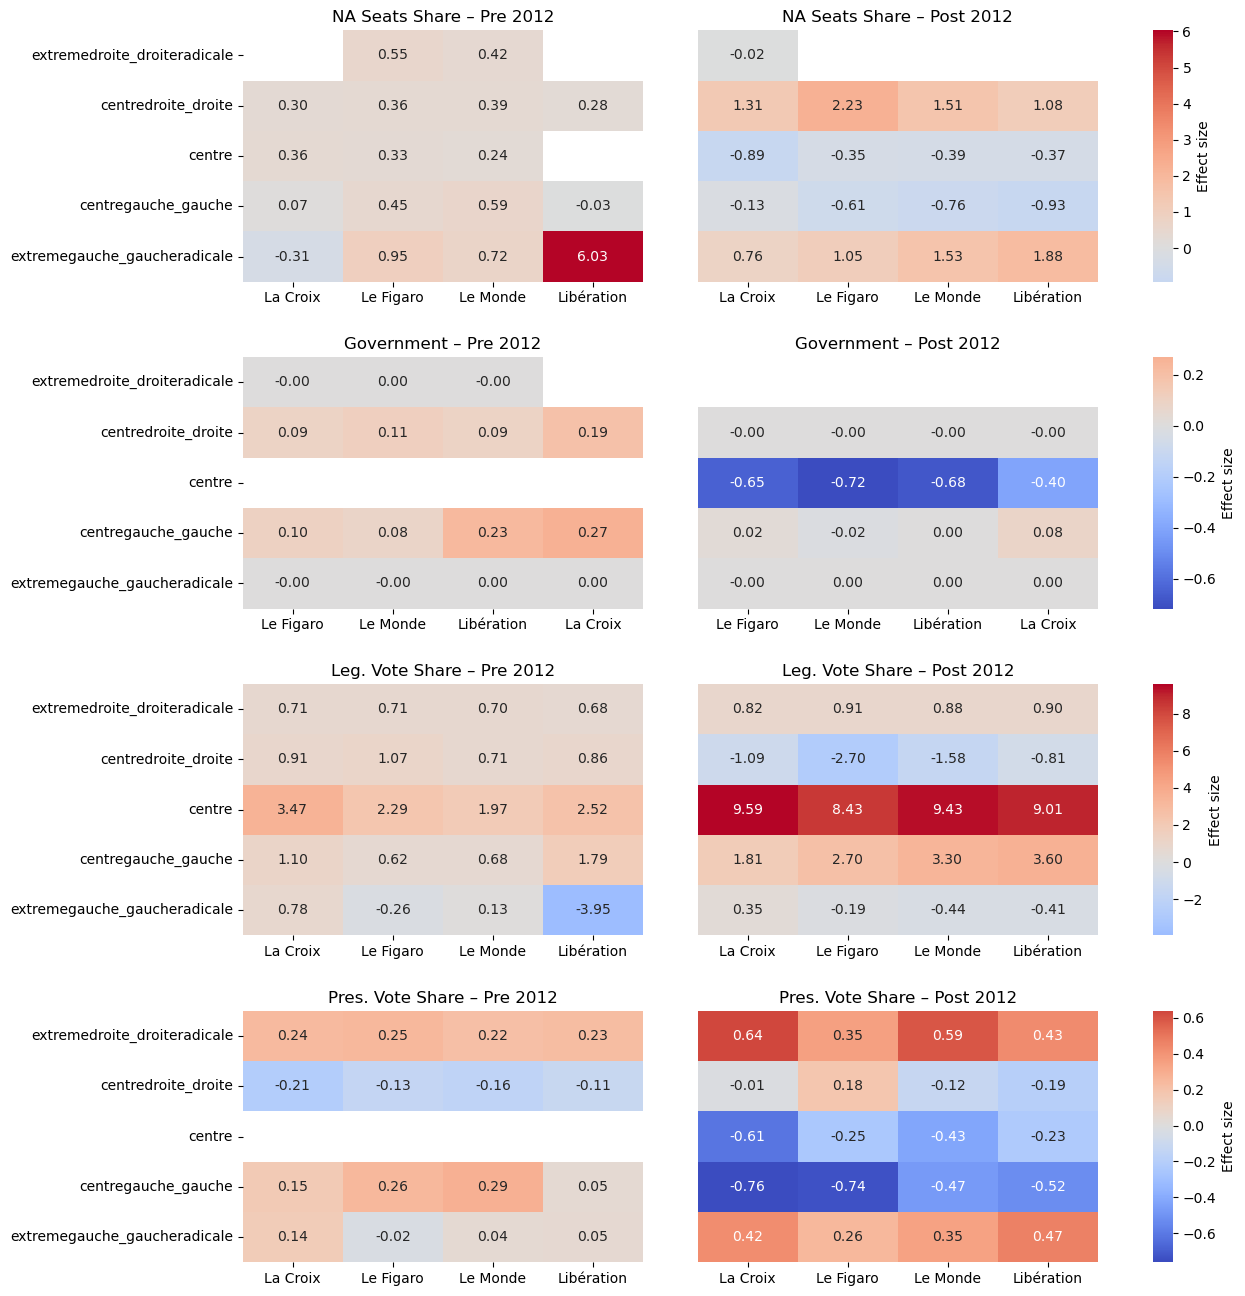

In [43]:
combinations = [
    ('na_share', 'pre2012'),
    ('na_share', 'post2012'),
    ('government', 'pre2012'),
    ('government', 'post2012'),
    ('leg_votes_share', 'pre2012'),
    ('leg_votes_share', 'post2012'),
    ('pres_votes_share', 'pre2012'),
    ('pres_votes_share', 'post2012'),
]

titles = [
    'NA Seats Share – Pre 2012',
    'NA Seats Share – Post 2012',
    'Government – Pre 2012',
    'Government – Post 2012',
    'Leg. Vote Share – Pre 2012',
    'Leg. Vote Share – Post 2012',
    'Pres. Vote Share – Pre 2012',
    'Pres. Vote Share – Post 2012',
]

heatmap_data = []
row_counts = []

for var, period in combinations:
    idx = results.index
    mask = (
        (idx.get_level_values(0) == var) &
        (idx.get_level_values('Journal') != 'Mediapart')
    )
    sub = results[mask][(period, 'params')]
    
    sub.index = sub.index.droplevel(0)
    pivot = sub.unstack(level=1)
    heatmap_data.append(pivot)
    row_counts.append(pivot.shape[0])


row_limits = []
for r in range(4):
    d1 = heatmap_data[2*r]
    d2 = heatmap_data[2*r+1]
    combined = pd.concat([d1, d2]).values.flatten()
    vmin, vmax = np.nanmin(combined), np.nanmax(combined)
    row_limits.append((vmin, vmax))

fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(
    4, 3,
    width_ratios=[1, 1, 0.05],
    height_ratios=[
        max(row_counts[0:2])/max(row_counts),
        max(row_counts[2:4])/max(row_counts),
        max(row_counts[4:6])/max(row_counts),
        max(row_counts[6:8])/max(row_counts)
    ],
    hspace=0.3,
    figure=fig
)

axes = [fig.add_subplot(gs[i, j]) for i in range(4) for j in range(2)]
cbar_axes = [fig.add_subplot(gs[i, 2]) for i in range(4)]

for idx, ax in enumerate(axes):
    row = idx // 2
    vmin, vmax = row_limits[row]
    sns.heatmap(
        heatmap_data[idx],
        ax=ax,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".2f",
        vmin=vmin,
        vmax=vmax,
        cbar=(idx % 2 == 1),
        cbar_ax=(cbar_axes[row] if idx % 2 == 1 else None),
        cbar_kws={'label': 'Effect size'}
    )

    ax.set_title(titles[idx])
    ax.set_xlabel('')
    if idx % 2 == 0:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelrotation=0)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_yticklabels([])

plt.show()